In [20]:
import pybamm
import matplotlib.pyplot as plt
#options = {"thermal": "lumped","SEI":"ec reaction limited", "SEI film resistance":"average", "SEI porosity change": "true",}
#options = {"thermal": "lumped", "lithium plating": "irreversible","loss of active material": "stress-driven","particle mechanics":"swelling only", "SEI":"ec reaction limited", "SEI film resistance":"average", "SEI porosity change": "true"}
#options = {"thermal": "lumped","SEI":"ec reaction limited", "SEI film resistance":"average", "SEI porosity change": "true","loss of active material": "stress-driven","particle mechanics":"swelling only"}
options = {"thermal": "lumped", "lithium plating": "irreversible","SEI":"ec reaction limited", "SEI film resistance":"average", "SEI porosity change": "true","loss of active material": "stress-driven","particle mechanics":"swelling only"}
model = pybamm.lithium_ion.SPM(options=options)

experiment = pybamm.Experiment(
    [
        (
            "Discharge at C/3 until 2.85 V",
            "Rest for 10 min",
            "Charge at C/3 until 4.2 V",
            "Hold at 4.2 V until 50 mA",
            "Rest for 20 min",
        ),
    ]
    * 1500,
    termination= "5% capacity"
)


parameter_values = pybamm.ParameterValues("Chen2020") #OKane2022

#sim.plot()

In [21]:
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-12*0.002})
# parameter_values.update({"Ratio of lithium moles to SEI moles": 1.0*2})
# parameter_values.update({"Inner SEI partial molar volume [m3.mol-1]": 9.585e-05*0.5})
#parameter_values.update({"Outer SEI partial molar volume [m3.mol-1]": 9.585e-05*0.5})
# parameter_values.update({"SEI resistivity [Ohm.m]": 200000.0*0.1})
parameter_values.update({"EC diffusivity [m2.s-1]": 2e-18*0+2.5e-22*4})
# parameter_values.update({"EC initial concentration in electrolyte [mol.m-3]": 4541.0*1})
# parameter_values.update({"SEI growth activation energy [J.mol-1]": 38000.0*0})

In [22]:
def graphite_volume_change_Ai2020(sto, c_s_max):
    """
    Graphite particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration
    Returns
    -------
    t_change:class:`pybamm.Symbol`
        volume change, dimensionless, normalised by particle volume
    """
    p1 = 145.907
    p2 = -681.229
    p3 = 1334.442
    p4 = -1415.710
    p5 = 873.906
    p6 = -312.528
    p7 = 60.641
    p8 = -5.706
    p9 = 0.386
    p10 = -4.966e-05
    t_change = (
        p1 * sto**9
        + p2 * sto**8
        + p3 * sto**7
        + p4 * sto**6
        + p5 * sto**5
        + p6 * sto**4
        + p7 * sto**3
        + p8 * sto**2
        + p9 * sto
        + p10
    )
    return t_change

In [23]:
def volume_change_Ai2020(sto, c_s_max):
    """
    Particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] > Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] > Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration
    Returns
    -------
    t_change:class:`pybamm.Symbol`
        volume change, dimensionless, normalised by particle volume
    """
    omega = pybamm.Parameter("Positive electrode partial molar volume [m3.mol-1]")
    t_change = omega * c_s_max * sto
    return t_change

In [24]:
parameter_values.update({"Positive electrode LAM constant proportional term [s-1]": 0.01/3600,
                         "Negative electrode LAM constant proportional term [s-1]": 0.02/3600,
                         
                         "Positive electrode LAM constant exponential term": 2.0*1.1,
                         "Negative electrode critical stress [Pa]": 60000000.0*1,
                         "Negative electrode LAM constant exponential term": 2.0*1.1,
                         "Positive electrode critical stress [Pa]": 375000000.0*1,
                         "Positive electrode partial molar volume [m3.mol-1]": 1.25e-05,
                         "Negative electrode partial molar volume [m3.mol-1]": 3.1e-06,
                         "Negative electrode Young's modulus [Pa]": 15000000000.0,
                         "Negative electrode Poisson's ratio": 0.3,
                         "Positive electrode Poisson's ratio": 0.2,
                         "Positive electrode Young's modulus [Pa]": 375000000000.0,
                         "Negative electrode reference concentration for free of deformation [mol.m-3]"
                         "": 0.0,
                         "Positive electrode reference concentration for free of deformation [mol.m-3]"
                         "": 0.0,
                         "Negative electrode volume change": graphite_volume_change_Ai2020,
                         "Positive electrode volume change": volume_change_Ai2020,}, check_already_exists=False)

#parameter_values.update({"Positive electrode LAM constant exponential term": 2.0*1.1})
#parameter_values.update({"Negative electrode critical stress [Pa]": 60000000.0*0.0009})
#parameter_values.update({"Negative electrode LAM constant exponential term": 2.0*1.1})

#parameter_values.update({"Positive electrode critical stress [Pa]": 375000000.0*0.00001})




In [25]:
#timer = pybamm.Timer()
sim = pybamm.Simulation(model, parameter_values=parameter_values,experiment=experiment)
#sim = pybamm.Simulation(model)
sim.solve(showprogress=True)

KeyError: "'Typical plated lithium concentration [mol.m-3]' not found. Best matches are ['Bulk solvent concentration [mol.m-3]', 'Lithium interstitial reference concentration [mol.m-3]', 'EC initial concentration in electrolyte [mol.m-3]']"

In [16]:
# parameter_values.update({"Negative electrode OCP entropic change [V.K-1]": -0.0002})
# parameter_values.update({"Positive electrode OCP entropic change [V.K-1]": -0.0004})

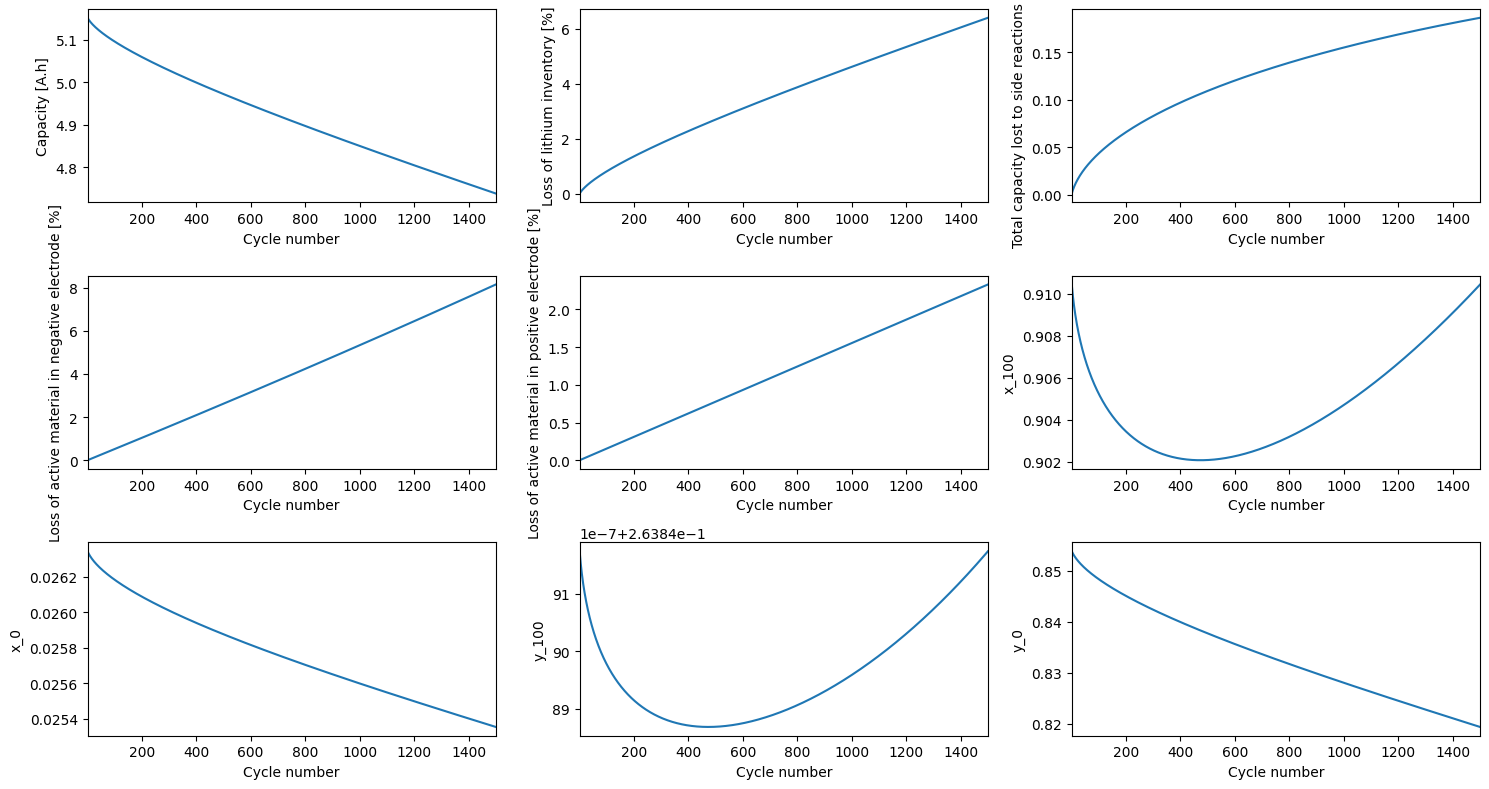

array([[<Axes: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Total capacity lost to side reactions [A.h]'>],
       [<Axes: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='x_100'>],
       [<Axes: xlabel='Cycle number', ylabel='x_0'>,
        <Axes: xlabel='Cycle number', ylabel='y_100'>,
        <Axes: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [17]:
pybamm.plot_summary_variables(sim.solution)

In [32]:
#parameter_values.search("partial molar")

: 

In [33]:
sim.plot(["X-averaged cell temperature [K]", "Total heating [W.m-3]", "Current [A]", "Voltage [V]"])

In [ ]:
sim.plot(['Loss of capacity to negative lithium plating [A.h]','Loss of capacity to negative SEI [A.h]','Total capacity lost to side reactions [A.h]',"Discharge capacity [A.h]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=923.6267737335378, step=9.236267737335378), …

In [ ]:
sim.plot(['X-averaged negative electrode porosity','X-averaged negative particle stoichiometry','X-averaged positive particle stoichiometry','X-averaged positive particle surface stoichiometry','X-averaged negative particle surface stoichiometry'])

interactive(children=(FloatSlider(value=0.0, description='t', max=1928.3285133042693, step=19.283285133042693)…

In [ ]:
sim.plot(['X-averaged negative electrode porosity','X-averaged negative particle stoichiometry','X-averaged positive particle stoichiometry','X-averaged positive particle surface stoichiometry','X-averaged negative particle surface stoichiometry'])

interactive(children=(FloatSlider(value=0.0, description='t', max=1928.3285133042693, step=19.283285133042693)…

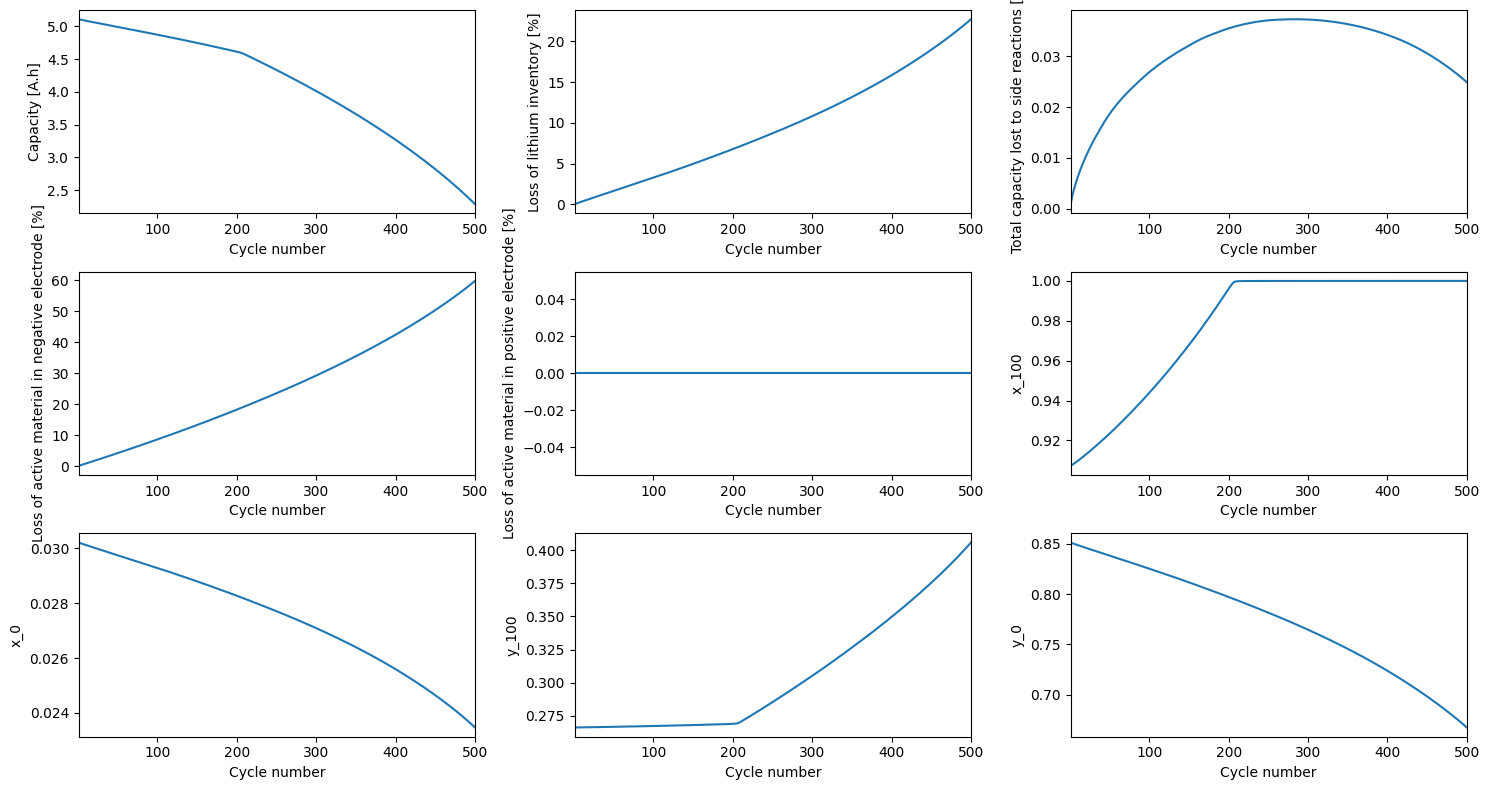

array([[<Axes: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Total capacity lost to side reactions [A.h]'>],
       [<Axes: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='x_100'>],
       [<Axes: xlabel='Cycle number', ylabel='x_0'>,
        <Axes: xlabel='Cycle number', ylabel='y_100'>,
        <Axes: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [8]:
pybamm.plot_summary_variables(sim.solution)

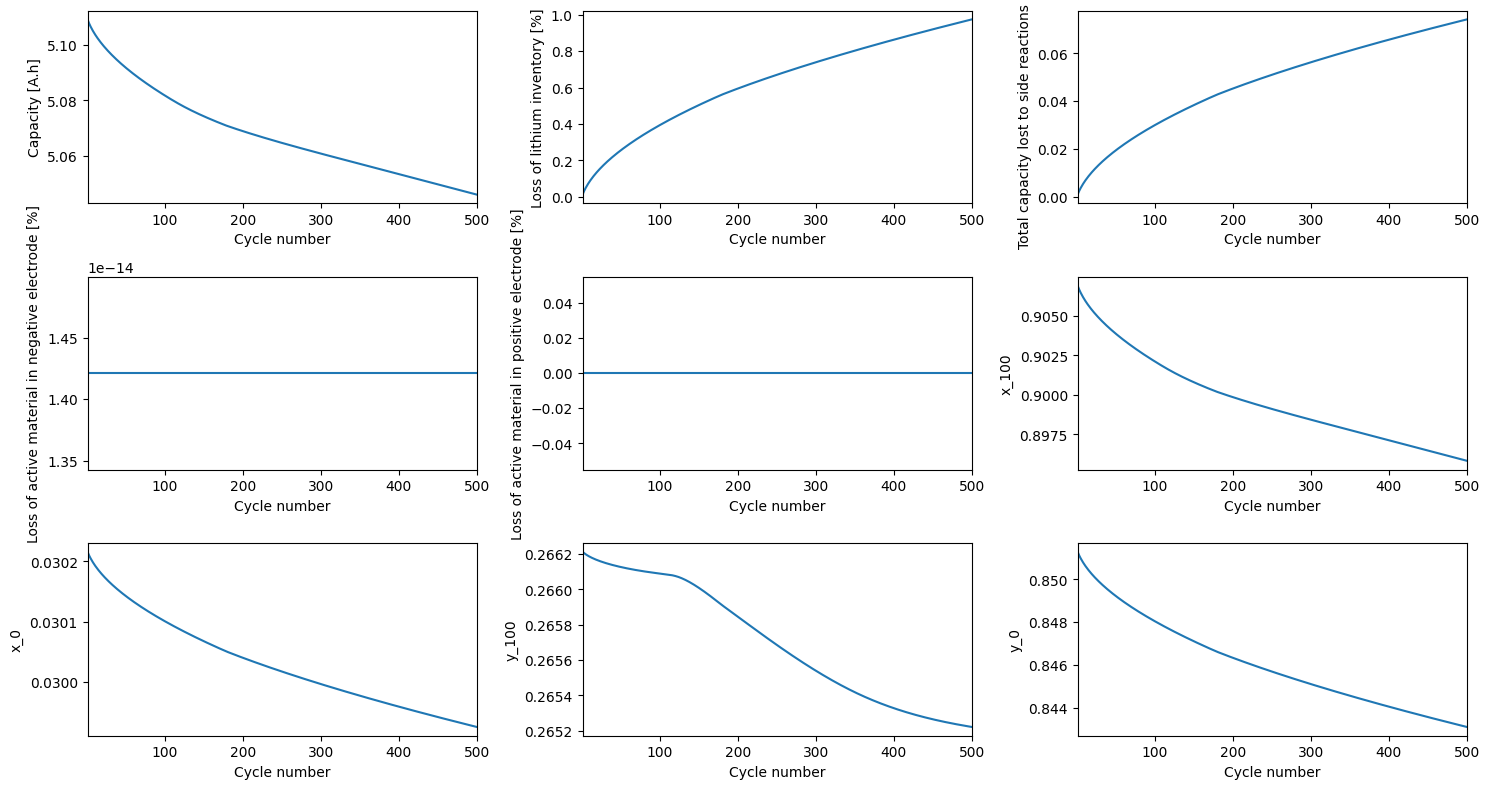

array([[<Axes: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Total capacity lost to side reactions [A.h]'>],
       [<Axes: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='x_100'>],
       [<Axes: xlabel='Cycle number', ylabel='x_0'>,
        <Axes: xlabel='Cycle number', ylabel='y_100'>,
        <Axes: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [42]:
pybamm.plot_summary_variables(sim.solution)

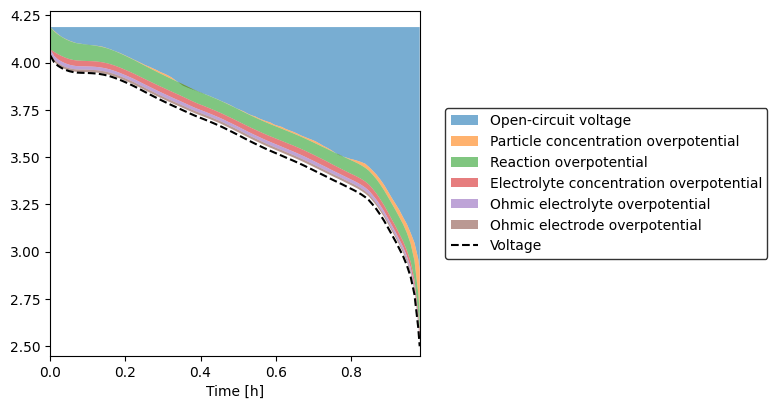

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [12]:
sim.plot_voltage_components()

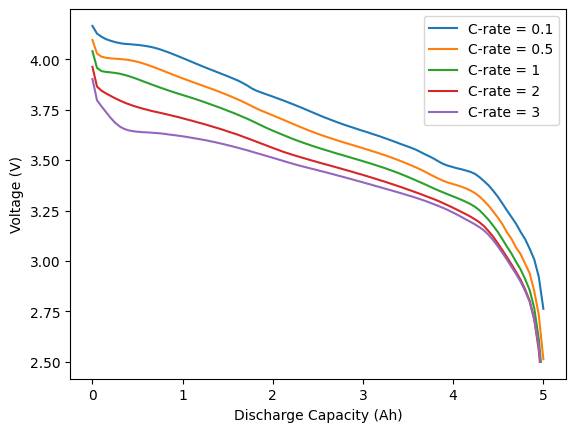

In [6]:
import pybamm

#options = {"thermal": "lumped", "lithium plating": "irreversible","loss of active material": "stress-driven","particle mechanics":"swelling only", "SEI":"ec reaction limited", "SEI film resistance":"average", "SEI porosity change": "true"}
options={"thermal": "lumped"}
model = pybamm.lithium_ion.DFN(options=options)
import matplotlib.pyplot as plt

C_rates = [0.1,0.5, 1, 2, 3]

parameter_values = pybamm.ParameterValues("OKane2022")

for Crate in C_rates:
    sim = pybamm.Simulation(model, parameter_values=parameter_values, C_rate=Crate)
    #sim = pybamm.Simulation(model)
    sim.solve([0, 3600/Crate])
    discharge_capacity = sim.solution["Discharge capacity [A.h]"].entries
    voltage = sim.solution["Voltage [V]"].entries
    plt.plot(discharge_capacity,voltage, label =f"C-rate = {Crate}")
   


plt.xlabel("Discharge Capacity (Ah)")
plt.ylabel("Voltage (V)")
plt.legend()
plt.show()

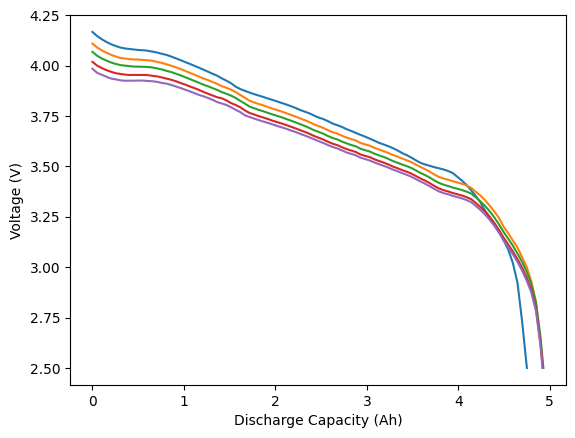

In [1]:
import pybamm

options = {"thermal": "lumped", "lithium plating": "irreversible","loss of active material": "stress-driven","particle mechanics":"swelling only", "SEI":"ec reaction limited", "SEI film resistance":"average", "SEI porosity change": "true"}
model = pybamm.lithium_ion.SPM(options=options)
import matplotlib.pyplot as plt

C_rates = [0.1,0.5, 1, 2, 3]

parameter_values = pybamm.ParameterValues("OKane2022")

for Crate in C_rates:
    sim = pybamm.Simulation(model, parameter_values=parameter_values, C_rate=Crate)
    #sim = pybamm.Simulation(model)
    sim.solve([0, 3600/Crate])
    discharge_capacity = sim.solution["Discharge capacity [A.h]"].entries
    time_entries = sim.solution["Time [s]"].entries
    voltage = sim.solution["Voltage [V]"].entries
    plt.plot(discharge_capacity,voltage)
   
   


plt.xlabel("Discharge Capacity (Ah)")
plt.ylabel("Voltage (V)")
plt.show()

In [12]:
sim.plot(['Loss of capacity to negative lithium plating [A.h]','Loss of capacity to negative SEI [A.h]','Total capacity lost to side reactions [A.h]'])
sim.plot(["Discharge capacity [A.h]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=68.87329561476587, step=0.6887329561476586),…

interactive(children=(FloatSlider(value=0.0, description='t', max=68.87329561476587, step=0.6887329561476586),…

In [8]:
model.variable_names()

['Time [s]',
 'Time [min]',
 'Time [h]',
 'x [m]',
 'x_n [m]',
 'x_s [m]',
 'x_p [m]',
 'r_n [m]',
 'r_p [m]',
 'Current variable [A]',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Throughput capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Negative electrode interface utilisation variable',
 'X-averaged negative electrode interface utilisation variable',
 'Negative electrode interface utilisation',
 'X-averaged negative electrode interface utilisation',
 'Positive electrode interface utilisation variable',
 'X-averaged positive electrode interface utilisation variable',
 'Positive electrode interface utilisation',
 'X-averaged positive electrode interface utilisation',
 'Negative particle crack length [m]',
 'X-averaged negative particle crack length [m]',
 'Negative particle cracking rate [m.s-1]',
 'X-averaged negative particle cracking rate [m.s-1]',
 'Positive particle crack length [m]',
 'X-averaged positive 

In [19]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Ferran Brosa Planella and W. Dhammika Widanage. Systematic derivation of a Single Particle Model with Electrolyte and Side Reactions (SPMe+SR) for degradation of lithium-ion batteries. Submitted for publication, ():, 2022. doi:.
[4] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Soc